In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import tqdm
import os
import glob
import torch
import matplotlib.pyplot as plt
import pandas as pd
import cv2

from mirror.visualisations.core import GradCam
from estimators.models import *
from estimators.utils import get_learner, get_probs_and_labels_from_preds, get_patches_form_df, load_model_from_name, device
from estimators.datasets.TraversabilityDataset import TraversabilityDataset, get_transform

from os import path
from Config import Config
from utilities.patches import *


class StorePredictions():
    def __init__(self, model_name, model_dir, store_dir):
        self.model_name = model_name
        self.model_dir = model_dir
        self.dfs = []
        self.df_path2df = {}
        self.store_dir = store_dir

    def handle_dataset(self, dataset):
        df = dataset.df
        learner, _ = get_learner(self.model_name, self.model_dir, callbacks=[], dataset=dataset)
        preds = learner.get_preds(learner.data.test_dl)
        probs, labels = get_probs_and_labels_from_preds(preds)

        df['out_0'] = probs[:, 0]
        df['out_1'] = probs[:, 1]
        df['prediction'] = labels.cpu().tolist()

        return df

    def store(self):
        for df_path, df in tqdm.tqdm(self.df_path2df.items()):
            file_name = path.basename(df_path)
            map_name = path.basename(path.split(df_path)[0])
            out_path = path.normpath('{}/{}/'.format(self.store_dir, map_name))
            os.makedirs(out_path, exist_ok=True)
            out_path = path.normpath('{}/{}'.format(out_path, file_name))
            df.to_csv(out_path)

    def restore(self):
        dfs_path = glob.glob(self.store_dir + '/**/*.csv')

        for df_path in tqdm.tqdm(dfs_path):
            df = pd.read_csv(df_path)
            self.df_path2df[df_path] = df
            self.dfs.append(df)

    def __call__(self, datasets):
        bar = tqdm.tqdm(datasets)
        for dataset in bar:
            if type(dataset) is not TraversabilityDataset: raise ValueError('inputs must be of type TraversabilityDataset')
            bar.set_description('[INFO] Reading {}'.format(dataset.df_path))
            if len(dataset) > 0:
                df = self.handle_dataset(dataset)
                self.dfs.append(df)
                self.df_path2df[dataset.df_path] = self.dfs[-1]

        return self.dfs






/home/francesco/.local/lib/python3.6/site-packages/skimage/novice/__init__.py:103: UserWarning: The `skimage.novice` module was deprecated in version 0.14. It will be removed in 0.16.
  warnings.warn("The `skimage.novice` module was deprecated in version 0.14. "


In [ ]:
concat = TraversabilityDataset.from_paths(Config.DATA_ROOT, [Config.DATA_DIR], tr=0.45, transform=get_transform(scale=10))
store = StorePredictions(Config.BEST_MODEL_NAME, Config.BEST_MODEL_DIR, '/home/francesco/Desktop/store-test/')
dfs = store(concat.datasets)
# store.restore()

In [ ]:
class Best():
    name = 'best'
    def __call__(self, df):
        df = df.loc[df['label'] == 1]
        return df.sort_values(['out_1'], ascending=False)

class Worst():
    name = 'worst'
    def __call__(self, df):
        df = df.loc[df['label'] == 0]
        return df.sort_values(['out_0'], ascending=False)

class FalseNegative():
    name = 'false_negative'
    def __call__(self, df):
        return false_something(df, 0)

class FalsePositive():
    name = 'false_positive'
    def __call__(self, df):
        return false_something(df, 1)


def false_something(df, something):
    neg = df.loc[df['label'] == something]
    return neg.loc[neg['prediction'] != something]



In [ ]:
class FilterPatches():
    def __init__(self, transform=None):
        self.df = None
        self.transform = transform
    
    def transform_patches(self, patches):
        
        return [self.transform(patch) for patch in patches]
    
    def filter_patches(self, df, image_dir):
        return self.transform_patches(get_patches_form_df(df, image_dir))

    def __call__(self, df, image_dir, filter_fn, n=2):
        filtered_df = filter_fn(df)
        filtered_df = filtered_df.head(n)
        return filtered_df, self.filter_patches(filtered_df, image_dir),

class Convert2Patches():
    def __call__(self, data):
        df, patches = data
        return df, Patch.from_tensors(patches)
    
class GradCamVisualization():

    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.grad_cam = GradCam(model.to(self.device), self.device)
    
    def get_grad_cam(self, patch):
        img = patch.unsqueeze(0).to(self.device)

        _, info = self.grad_cam(img, None, target_class=None)

        cam = info['cam'].cpu().numpy()
        cam = cv2.resize(cam, (patch.shape[1], patch.shape[2]))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        
        return cam
    
    def __call__(self, data):
        df, patches = data
        
        grad_cams = [self.get_grad_cam(patch) for patch in patches]
        
        return df, patches, grad_cams

In [ ]:
def get_all_interesting_patches(transform, df, image_dir):
    filters = [Best(), Worst(), FalseNegative(), FalsePositive()]
    result = {}
    
    f_patch = FilterPatches(transform=transform)
    c_patch = Convert2Patches()
    
    for f in filters:
        result[f.name] = c_patch(f_patch(df, image_dir, f))
        
    return result
    

In [ ]:
class PlotInterestingPatches():
    def plot_all(self, patches, title):
        for patch in patches:
            patch.plot3d(title)
            
    def make_title(self, metric, row):
        return 'advancement={:.2f} prediction = {} ground truth = {}'.format(row['advancement'], row['prediction'], row['label'])
    
    def __call__(self, data):
        for metric, (df, patches) in data.items():
            print(metric)
            for (idx, row), patch in zip(df.iterrows(), patches):
                    patch.plot3d(self.make_title(metric, row))
            
        

In [ ]:
data = get_all_interesting_patches(get_transform(scale=10), store.dfs[0], Config.DATA_ROOT)

In [ ]:
plot_patches = PlotInterestingPatches()
plot_patches(data)

In [ ]:
df, patches = data['worst']


In [ ]:
model = load_model_from_name(Config.BEST_MODEL_DIR + '/roc_auc.pth', Config.BEST_MODEL_NAME)

In [ ]:
grad_cam_vis = GradCamVisualization(model, device)

df, patches, grad_cam = grad_cam_vis(data['worst'])

In [ ]:
patches = Patch.from_tensors(patches)
grad_cam = Patch.from_hms(grad_cam)

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

for (idx, row), patch in zip(df.iterrows(), patches):
    patch.plot3d()
#     grad.plot3d()
    plt.title('advancement={:.2f} prediction = {} ground truth = {}'.format(row['advancement'], row['prediction'], row['label']))


In [ ]:
patches[0].plot2d()

In [ ]:
p = Patch.from_tensor(patches[0])

In [ ]:
hm = cv2.imread('/home/francesco/Documents/Master-Thesis/core/maps/test/querry-big-10.png')
hm = cv2.cvtColor(hm, cv2.COLOR_BGR2GRAY)

In [ ]:
import matplotlib.patches as mpatches


In [ ]:
 def plot_box_on_hm(row, hm, patch_size):
        fig = plt.figure()
        ax = plt.gca()
        x, y, ang, ad = row["hm_x"], \
                        row["hm_y"], \
                        row["pose__pose_e_orientation_z"], \
                        row["advancement"]

        sns.heatmap(hm / 255, vmin=0, vmax=1, ax=ax)

        rect = mpatches.Rectangle((x - patch_size // 2, y - patch_size // 2), patch_size,
                                  patch_size, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.show()

In [ ]:
plot_box_on_hm(df.iloc[10], hm, 88)

In [ ]:
p.plot2d()
plt.title(df.iloc[10]['advancement'])

In [ ]:
p.plot3d()

In [ ]:
%matplotlib notebook

In [9]:
MODEL = '/home/francesco/Desktop/carino/vaevictis/data/microresnet#4-gate=3x3-n=1-se=True-no-shift-0.001-88-1556121325.3923125/roc_auc.pth'
model = load_model_from_name(MODEL, 'microresnet#4-gate=3x3-n=1-se=True')
model.eval()

MicroResnet(
  (encoder): Encoder3x3(
    (gate): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layers): ModuleList(
      (0): ResNetLayer(
        (layer): Sequential(
          (0): BasicBlockSE(
            (convs): Sequential(
              (0): Sequential(
                (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (1): LeakyReLU(negative_slope=0.01)
                (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
              )
              (1): Sequential(
                (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (1): LeakyReLU(negative_slop

In [ ]:
np.linspace(0,1, 5)

In [ ]:
class TrueRampPatch(Patch):
    def __init__(self, shape, strenght=1, direction='up'):
        super().__init__(shape)
        self.strenght = strenght
        self.direction = direction
        
    def make(self):
        factors = np.linspace(0, self.strenght, self.hm.shape[0])
        if self.direction == 'down': factors *= -1

        self.hm = self.hm + factors
        return self.hm


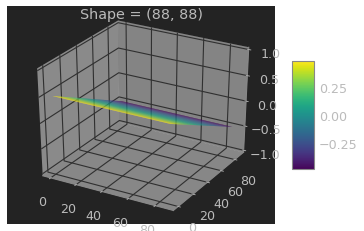

tensor([[ 0.1073, -0.1768]], grad_fn=<AddmmBackward>)


(tensor([[0.5706, 0.4294]], grad_fn=<SoftmaxBackward>), tensor([0]))

In [11]:
p = RampPatch((88,88), direction='down')
p()
tr = get_transform(scale=0.99)
x = tr(p.hm)
p.hm = x.squeeze().numpy()
p.plot3d()

pred = model(x.unsqueeze(0))
print(pred)
get_probs_and_labels_from_preds((pred,None))

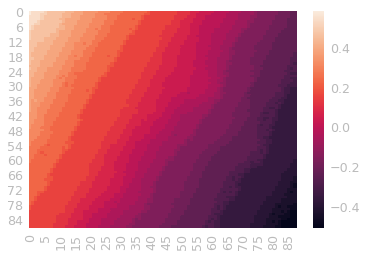

tensor([[ 0.2568, -0.2757]], grad_fn=<AddmmBackward>)


(tensor([[0.6301, 0.3699]], grad_fn=<SoftmaxBackward>), tensor([0]))

In [34]:
from utilities.postprocessing.utils import read_image

im = read_image('/media/francesco/saetta/krock-dataset/querry-down-hill/patches/1-120.png')
im = im.astype(np.float32)
im /= 255

tr = get_transform(scale=10)
x = tr(im)
p = Patch((88,88))
p.hm = x.squeeze().numpy()

p.plot2d()

pred = model(x.unsqueeze(0))
print(pred)
get_probs_and_labels_from_preds((pred,None))

In [ ]:
pred = model(x.unsqueeze(0))
print(pred)
get_probs_and_labels_from_preds((pred,None))